### Spam detection with Deep Learning

In [287]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow.keras
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score,precision_recall_curve, roc_curve,roc_auc_score

In [49]:
data_spam=pd.read_csv('spam.csv',encoding = "ISO-8859-1")
data_spam_original=data_spam.copy()

In [50]:
#Remove unncecessary columns and see the final dataframe
data_spam=data_spam[['v1','v2']]
data_spam=data_spam.rename({'v1':'Spam or Ham','v2':'SMS message'},axis=1)

In [51]:
data_spam.head()

,Spam or Ham,SMS message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [52]:
from sklearn.preprocessing import LabelBinarizer

In [53]:
lb=LabelBinarizer()
data_spam['Spam or Ham']=lb.fit_transform(data_spam['Spam or Ham'])

In [54]:
#See binarized classes - Spam or Ham
lb.classes_

array(['ham', 'spam'], dtype='<U4')

In [72]:
data_spam.shape

(5572, 2)

In [64]:
#Remove dots from the messages
data_spam['SMS message']=data_spam[['SMS message']].replace('\.','', regex=True)

In [74]:
#Check som random message
data_spam['SMS message'].iloc[np.random.randint(0,5571,1)]

4250    Omg Joanna is freaking me out She's looked thr...
Name: SMS message, dtype: object

In [75]:
from tensorflow import keras
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding
from tensorflow.keras.layers import SimpleRNN
from tensorflow.keras.datasets import imdb
from tensorflow.keras import initializers

In [78]:
#Compute number of words in a message
n_words_in_message=[]
for i in range(len(data_spam)):
    n_words_in_message.append(len(data_spam.loc[i,'SMS message'].split()))
np.mean(n_words_in_message)

15.418700646087581

In [79]:
#Important parameters
max_features = 5000  # This is used in loading the data, picks the most common (max_features) words
maxlen = 15  # maximum length of a sequence - truncate after this
batch_size = 32

In [131]:
#check merging in one text file
text=['']
for i in range(len(data_spam)):
    text[0]+=' '+data_spam.loc[i,'SMS message']
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(text)
sequences = tokenizer.texts_to_sequences(text)[0]
print('Elements in sequences',len(sequences),' Words in total',len(text[0].split()))

Elements in sequences 82517  Words in total 85913


In [209]:
#check understanding
list_1=tokenizer.texts_to_sequences(data_spam.loc[i,'SMS message'])
list_2=[]
list_1
for i in range(len(list_1)):
    try:
        list_2.append(list_1[i][0])
    except:
        continue

In [165]:
X_data=[]
for i in range(len(data_spam)):
    convertion_to_int_1=tokenizer.texts_to_sequences(data_spam.loc[i,'SMS message'])#makes a list of lists
    convertion_to_int_2=[]
    for i in range(len(convertion_to_int_1)):
        try:
            convertion_to_int_2.append(convertion_to_int_1[i][0])
        except:
            continue
    X_data.append(convertion_to_int_2)
X_data=np.array(X_data,dtype='object')
len(X_data[5])

110

In [248]:
data_spam['Spam or Ham'].value_counts(normalize=True)

0    0.865937
1    0.134063
Name: Spam or Ham, dtype: float64

In [249]:
y_data=data_spam['Spam or Ham']

In [250]:
from sklearn.model_selection import StratifiedShuffleSplit
sss=StratifiedShuffleSplit(n_splits=1,test_size=0.3,random_state=14)

In [251]:
#Stratified Train test split
train_ind, test_ind=next(sss.split(X_data, y_data))
X_train=X_data[train_ind]
X_test=X_data[test_ind]
y_train=y_data[train_ind]
y_test=y_data[test_ind]

In [252]:
y_train.value_counts(normalize=True)

0    0.865897
1    0.134103
Name: Spam or Ham, dtype: float64

In [227]:
#Convert to categorical
#y_train = tensorflow.keras.utils.to_categorical(y_train, num_classes)
#y_test = tensorflow.keras.utils.to_categorical(y_test, num_classes)

In [253]:
#Engenieering the sequences
X_train = sequence.pad_sequences(X_train, maxlen=maxlen)
X_test = sequence.pad_sequences(X_test, maxlen=maxlen)
print('x_train shape:', X_train.shape)
print('x_test shape:', X_test.shape)

x_train shape: (3900, 15)
x_test shape: (1672, 15)


In [254]:
#example of the sequence
X_train[123,:]

array([  4,  89,  89, 770, 284,   1,  89, 606,   1, 336,  89, 783, 186,
         1, 186])

In [255]:
y_test.shape

(1672,)

### Finally I can build a recurrent neural network

In [256]:
X_train.shape[1:]

(15,)

In [257]:
rnn_hidden_dim = 5
word_embedding_dim = 70
model_rnn = Sequential()
model_rnn.add(Embedding(max_features, word_embedding_dim))  #This layer takes each integer in the sequence
model_rnn.add(SimpleRNN(rnn_hidden_dim,
                    kernel_initializer=initializers.RandomNormal(stddev=0.001),
                    recurrent_initializer=initializers.Identity(gain=1.0),
                    activation='relu',
                    input_shape=X_train.shape[1:]))

model_rnn.add(Dense(1, activation='sigmoid'))

In [258]:
model_rnn.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, None, 70)          350000    
_________________________________________________________________
simple_rnn_4 (SimpleRNN)     (None, 5)                 380       
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 6         
Total params: 350,386
Trainable params: 350,386
Non-trainable params: 0
_________________________________________________________________


In [259]:
#Compiling the mode;
rmsprop = keras.optimizers.RMSprop(learning_rate = .0001)

model_rnn.compile(loss='binary_crossentropy',
              optimizer=rmsprop,
              metrics=['accuracy'])

In [260]:
model_rnn.fit(X_train, y_train,
          batch_size=batch_size,
          epochs=20,
          validation_data=(X_test, y_test))

Epoch 1/20
122/122 [==============================] - 2s 7ms/step - loss: 0.5931 - accuracy: 0.8636 - val_loss: 0.4805 - val_accuracy: 0.8660
Epoch 2/20
122/122 [==============================] - 1s 5ms/step - loss: 0.3852 - accuracy: 0.8744 - val_loss: 0.3034 - val_accuracy: 0.8900
Epoch 3/20
122/122 [==============================] - 1s 5ms/step - loss: 0.2798 - accuracy: 0.8972 - val_loss: 0.2461 - val_accuracy: 0.9181
Epoch 4/20
122/122 [==============================] - 1s 5ms/step - loss: 0.2379 - accuracy: 0.9177 - val_loss: 0.2125 - val_accuracy: 0.9312
Epoch 5/20
122/122 [==============================] - 1s 5ms/step - loss: 0.2102 - accuracy: 0.9321 - val_loss: 0.1922 - val_accuracy: 0.9396
Epoch 6/20
122/122 [==============================] - 1s 5ms/step - loss: 0.1936 - accuracy: 0.9405 - val_loss: 0.1839 - val_accuracy: 0.9480
Epoch 7/20
122/122 [==============================] - 1s 5ms/step - loss: 0.1851 - accuracy: 0.9456 - val_loss: 0.1776 - val_accuracy: 0.9486
Epoch 

In [261]:
scores=model_rnn.evaluate(X_test,y_test)
print('Performance of the model\n Validation set: Loss is {:.4f}, accuracy is {:.4f}'.format(scores[0],scores[1]) )

53/53 [==============================] - 0s 2ms/step - loss: 0.1703 - accuracy: 0.9522
Performance of the model
 Validation set: Loss is 0.1703, accuracy is 0.9522


In [262]:
#Prediction check
y_pred=model_rnn.predict(X_test)
np.argmax(y_pred)

1111

In [263]:
y_pred[1111]

array([0.9999635], dtype=float32)

In [266]:
#Convert the classes to 0 and 1 (y_pred_2 is a new variable here)
y_pred_2=[]
for y_pred_i in y_pred:
    if y_pred_i >=0.5:
        y_pred_2.append(1)
    elif y_pred_i < 0.5:
        y_pred_2.append(0)

In [268]:
accuracy_score(y_test,y_pred_2)

0.9521531100478469

In [270]:
print(classification_report(y_test,y_pred_2))

              precision    recall  f1-score   support

           0       0.96      0.99      0.97      1448
           1       0.90      0.72      0.80       224

    accuracy                           0.95      1672
   macro avg       0.93      0.85      0.89      1672
weighted avg       0.95      0.95      0.95      1672



Text(0.5, 1.0, 'Confusion matrix of SPAM determination with neural networks')

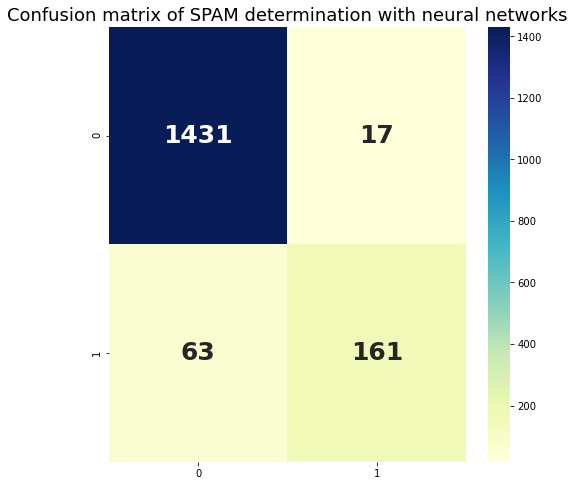

In [278]:
#Determine finally the confusion matrix and plot it
conf_matrix=confusion_matrix(y_test,y_pred_2)
_, ax = plt.subplots(figsize=(8,8))
ax=sns.heatmap(conf_matrix,cmap="YlGnBu",annot=True, fmt='d',annot_kws={"size": 25, "weight": "bold"})
ax.set_title('Confusion matrix of SPAM determination with neural networks',fontsize=18)

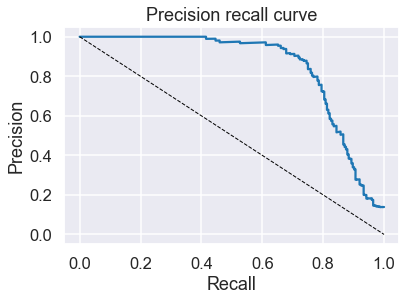

In [303]:
precision, recall,_=precision_recall_curve(y_test,y_pred)
#Preciosion recall curve
sns.set_context('talk')
sns.set_style('dark')
plt.plot(recall,precision)
plt.plot([0, 1], [1, 0], 'k--', linewidth=1)  # roc curve for random model
plt.title('Precision recall curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.grid(True)

[Text(0.5, 1.0, 'ROC Curve for Deep Learning model on Spam determination'),
 (-0.01, 1.01),
 (-0.01, 1.01)]

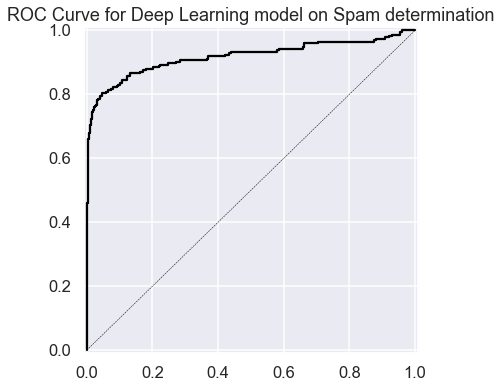

In [296]:
#ROC AUC curve
fpr, tpr, _ = roc_curve(y_test, y_pred)
fig, ax = plt.subplots(figsize=(6, 6))
ax.plot(fpr, tpr, 'k-')
ax.plot([0, 1], [0, 1], 'k--', linewidth=.5)  # roc curve for random model
ax.grid(True)
ax.set(title='ROC Curve for Deep Learning model on Spam determination',
           xlim=[-0.01, 1.01], ylim=[-0.01, 1.01])